# Image Classification with CNN and PCA  
**DS510 Team Project – City University of Seattle**

### Project Team
- Dawit Hailu, MSAI – hailudawith@cityuniversity.edu  
- Geraldine Marten-Ellis, MSCS – martenellisgeraldin@cityuniversity.edu  
- Jan McConnell, MSDS – janmcconnell@cityuniversity.edu  
- Aaron Smith, MSCS – smithaaron@cityuniversity.edu

## Environment Setup Instructions

To run this notebook:

1. Create and activate a virtual environment.
2. Install the required packages:

```bash
pip install -r requirements.txt

In [12]:
# Import standard libraries
import os              # For navigating the filesystem and joining paths
import numpy as np     # For efficient numerical operations and array handling
from PIL import Image  # From the Pillow library: used for opening and processing images

# Set the base directory where image folders are stored
data_dir = "dataset"

# Set the desired image size (width, height) for resizing
img_size = (64, 64)  # All images will be resized to 64×64 pixels

# Initialize empty lists to hold image data and corresponding labels
X = []  # Stores image arrays
y = []  # Stores label integers
label_map = {}  # Maps class names (folder names) to numeric label IDs

# Loop through each class folder (e.g., 'cat', 'dog', 'bird') in sorted order
for idx, class_name in enumerate(sorted(os.listdir(data_dir))):
    class_path = os.path.join(data_dir, class_name)  # Full path to the class folder
    if os.path.isdir(class_path):  # Ensure it's a directory
        label_map[class_name] = idx  # Map folder name to a unique label index
        for filename in os.listdir(class_path):  # Loop through image files
            img_path = os.path.join(class_path, filename)  # Full image path
            try:
                # Open the image, convert to grayscale ("L"), and resize
                with Image.open(img_path).convert("L") as img:
                    img = img.resize(img_size)  # Resize to 64×64
                    X.append(np.array(img))    # Convert image to NumPy array and store
                    y.append(idx)              # Store the class label
            except Exception as e:
                # If loading fails, print the error message
                print(f"Failed to load {img_path}: {e}")

# Convert image and label lists to NumPy arrays for processing
X = np.array(X)
y = np.array(y)

# Print summary of dataset
print(f"Loaded {X.shape[0]} images")            # Total number of images
print(f"Image shape: {X.shape[1:]} (grayscale)") # Dimensions of a single image
print("Label mapping:", label_map)              # Mapping from class name to label

Loaded 150 images
Image shape: (64, 64) (grayscale)
Label mapping: {'bird': 0, 'cat': 1, 'dog': 2}


Original shape: (150, 4096)
Reduced shape: (150, 86)
Plot saved to visualizations\pca_explained_variance.png


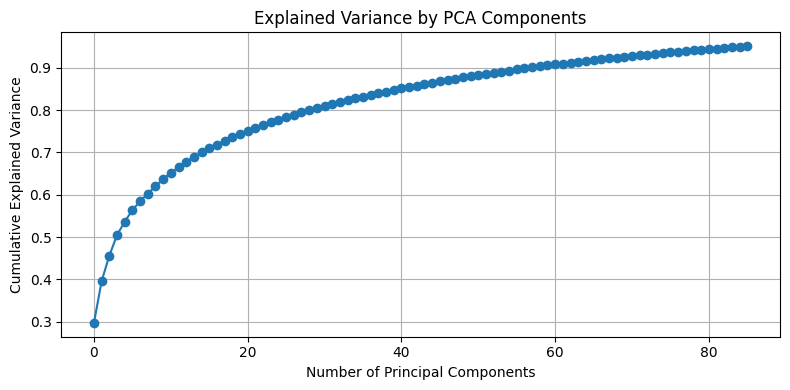

In [13]:
# Import PCA and standardization tools from scikit-learn
from sklearn.decomposition import PCA               # Used to reduce the number of features (dimensions)
from sklearn.preprocessing import StandardScaler    # Standardizes features by removing the mean and scaling to unit variance

# Import Matplotlib for plotting
import matplotlib.pyplot as plt                     # Used to create the explained variance plot

# Import OS for working with file paths
import os                                           # Helps with constructing the path to save the plot

# Step 1: Flatten each 64×64 image to a 1D array (length = 4096)
# Neural networks and PCA typically require 2D inputs (samples × features)
X_flat = X.reshape(X.shape[0], -1)  # Shape becomes (150, 4096)

# Step 2: Normalize pixel values to range [0, 1]
# Pixel values originally range from 0 to 255; dividing ensures they are on a consistent scale
X_flat = X_flat / 255.0

# Step 3: Standardize the features to mean=0 and variance=1
# PCA is sensitive to the scale of the input features, so standardization is important
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# Step 4: Perform PCA to reduce dimensionality
# We retain enough components to explain 95% of the variance in the dataset
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Step 5: Print the shapes of the original and PCA-reduced feature sets
# This confirms how much dimensionality reduction was achieved
print(f"Original shape: {X_flat.shape}")  # Example: (150, 4096)
print(f"Reduced shape: {X_pca.shape}")    # Example: (150, 86)

# Step 6: Plot the cumulative explained variance to visualize how many components are needed
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.tight_layout()

# Step 7: Save the plot to the 'visualizations' folder for reference in the report or presentation
output_path = os.path.join("visualizations", "pca_explained_variance.png")
plt.savefig(output_path)
print(f"Plot saved to {output_path}")

# Step 8: Display the plot in the notebook
plt.show()

## Train/Test Split

- To evaluate our classifier's performance, we need to divide the dataset into training and testing subsets. We will use an 80/20 split, with 80% of the data used for training the model and 20% held out for testing.
- This is a common convention in supervised learning that offers a good trade-off between model training and evaluation. It ensures there is enough data to train the model while still preserving a representative portion for testing.
- We also use stratified sampling to maintain the original distribution of class labels (bird, cat, dog) across both sets. This ensures each class is fairly represented in both the training and testing datasets.

In [18]:
# Import train_test_split to split the original image data
from sklearn.model_selection import train_test_split

# Step 1: Split the original grayscale image data (X) and labels (y)
# We use stratify=y to preserve the distribution of class labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 2: Print shape of the results for confirmation
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (120, 64, 64)
X_test shape: (30, 64, 64)
y_train shape: (120,)
y_test shape: (30,)


## CNN Model Architecture and Training

To classify the reduced image data, we will use a Convolutional Neural Network (CNN) built with TensorFlow and Keras. CNNs are commonly used for image classification tasks because they can capture spatial hierarchies through convolutional layers.

Since Principal Component Analysis (PCA) has already reduced the image dimensionality, this CNN will be relatively shallow. Our focus is on demonstrating classification capability, not on training a deep or highly optimized model.

This section includes the following steps:

- Defining a simple CNN architecture using Keras `Sequential`
- Compiling the model with the `Adam` optimizer and `categorical_crossentropy` loss (for one-hot encoded labels)
- Training the model using the training data
- Evaluating classification performance on the held-out test set

---

We will define a convolutional neural network (CNN) using Keras' `Sequential` interface to classify the grayscale images. The model will be compiled, trained, and evaluated using the PCA-reduced dataset.

- Training accuracy and test accuracy will be plotted and saved in the `visualizations` folder.

Epoch 1/10


c:\Users\JanMc\Dropbox\Education\_GitHub_coursework\janmcconnellCityU-coursework\DS510 Data Mining\TEAM_PROJECT\DS510_Team_Project\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3500 - loss: 73.9482 - val_accuracy: 0.3000 - val_loss: 4.4051
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3917 - loss: 1.5562 - val_accuracy: 0.2333 - val_loss: 1.2087
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7333 - loss: 0.7312 - val_accuracy: 0.4000 - val_loss: 1.5643
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8500 - loss: 0.4062 - val_accuracy: 0.4333 - val_loss: 1.7982
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9667 - loss: 0.1813 - val_accuracy: 0.4000 - val_loss: 2.0947
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9583 - loss: 0.1304 - val_accuracy: 0.2667 - val_loss: 2.4641
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9917 - loss: 0.0924 - val_accuracy: 0.3667 - val_loss: 4.3690
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9917 - loss: 0.0691 - val_accuracy: 0.2667 - val_loss: 2

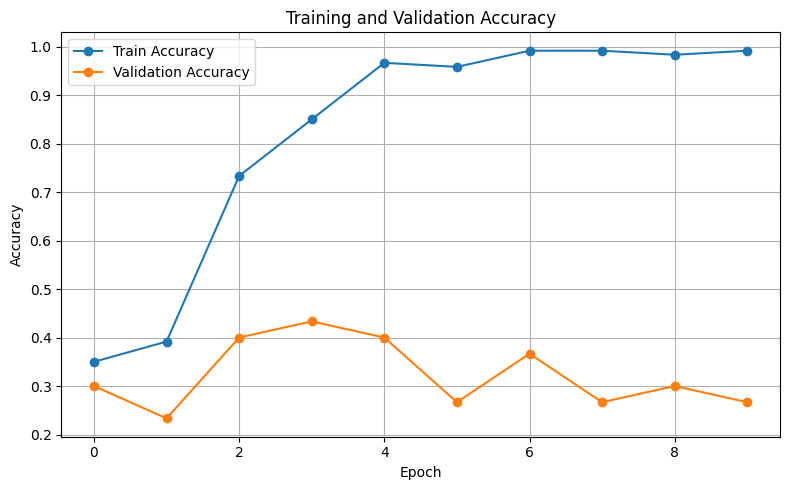

In [19]:
# Import required libraries for building and training the CNN
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Step 1: One-hot encode the labels (required for categorical classification)
# Converts labels like [0, 1, 2] into format like [[1,0,0], [0,1,0], [0,0,1]]
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=3)

# Step 2: Reshape the input data to add a channel dimension
# CNN expects input shape to be (samples, height, width, channels)
X_train_reshaped = X_train.reshape(-1, 64, 64, 1)
X_test_reshaped = X_test.reshape(-1, 64, 64, 1)

# Step 3: Define a simple CNN architecture using Keras Sequential API
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 output classes with softmax activation
])

# Step 4: Compile the model
# Using Adam optimizer and categorical crossentropy loss
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 5: Train the model using training data
history = model.fit(
    X_train_reshaped, y_train_cat,
    epochs=10,
    batch_size=8,
    validation_data=(X_test_reshaped, y_test_cat)
)

# Step 6: Evaluate the trained model on test data
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_cat)
print(f"\nTest accuracy: {test_acc:.2f}")

# Step 7: Plot and save training vs. validation accuracy over epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot to the 'visualizations' folder
plot_path = "visualizations/cnn_training_accuracy.png"
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")
plt.show()

## Model Evaluation: Confusion Matrix

To better understand the model's classification performance, we will generate a **confusion matrix**.  
This matrix shows how many times the model predicted each class correctly or incorrectly, relative to the true labels.

Since our model outputs class probabilities (after softmax), we will convert the predictions to **class indices** by using `np.argmax`.  
Then, we will compare these predicted labels to the true labels and visualize the result using `confusion_matrix` and `ConfusionMatrixDisplay`.

This will help us identify:
- Which classes are being misclassified
- Whether the model has a strong bias toward one or more classes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Confusion matrix saved to visualizations\cnn_confusion_matrix.png


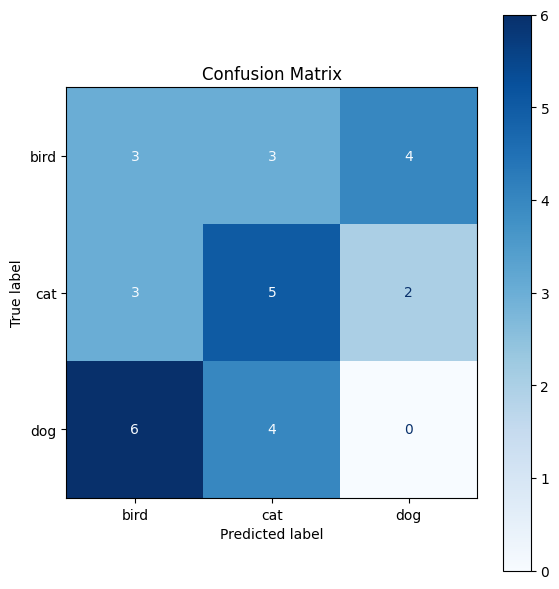

In [20]:
# Import required libraries for confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Get predicted class labels from model
# Model outputs probabilities for each class; we convert to class indices using argmax
y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 2: Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 3: Display the confusion matrix with labels from the label_map
class_names = list(label_map.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Step 4: Plot and save the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format='d')  # 'd' formats as integer

plt.title("Confusion Matrix")
plt.tight_layout()

# Save to visualizations folder
cm_path = os.path.join("visualizations", "cnn_confusion_matrix.png")
plt.savefig(cm_path)
print(f"Confusion matrix saved to {cm_path}")

plt.show()

## Evaluation Summary: PCA-Based CNN Model

The convolutional neural network (CNN) trained on PCA-reduced grayscale images completed 10 training epochs. While the training accuracy was high (approaching 99%), the test accuracy plateaued around **27%**, indicating potential overfitting and loss of important spatial information during dimensionality reduction.

The confusion matrix shows that the model struggled to differentiate between classes, especially for the "dog" category, which was frequently misclassified. This suggests that while PCA effectively reduced the number of input features, it may have also removed image characteristics essential for distinguishing between similar-looking animals.

These results align with the expected tradeoffs of PCA: lower dimensionality and faster training, but at the cost of reduced classification accuracy. We will later compare this performance with a CNN trained on the **original image data without PCA** to determine whether dimensionality reduction is beneficial in this context.

Epoch 1/10


c:\Users\JanMc\Dropbox\Education\_GitHub_coursework\janmcconnellCityU-coursework\DS510 Data Mining\TEAM_PROJECT\DS510_Team_Project\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3250 - loss: 1.1511 - val_accuracy: 0.3333 - val_loss: 1.1014
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3250 - loss: 1.0973 - val_accuracy: 0.3667 - val_loss: 1.1032
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3333 - loss: 1.1092 - val_accuracy: 0.3333 - val_loss: 1.1007
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4500 - loss: 1.0830 - val_accuracy: 0.3333 - val_loss: 1.1023
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5667 - loss: 1.0421 - val_accuracy: 0.2667 - val_loss: 1.1167
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6917 - loss: 0.8935 - val_accuracy: 0.3333 - val_loss: 1.2803
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7167 - loss: 0.8299 - val_accuracy: 0.4000 - val_loss: 1.2342
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8000 - loss: 0.6471 - val_accuracy: 0.3667 - val_loss: 1.

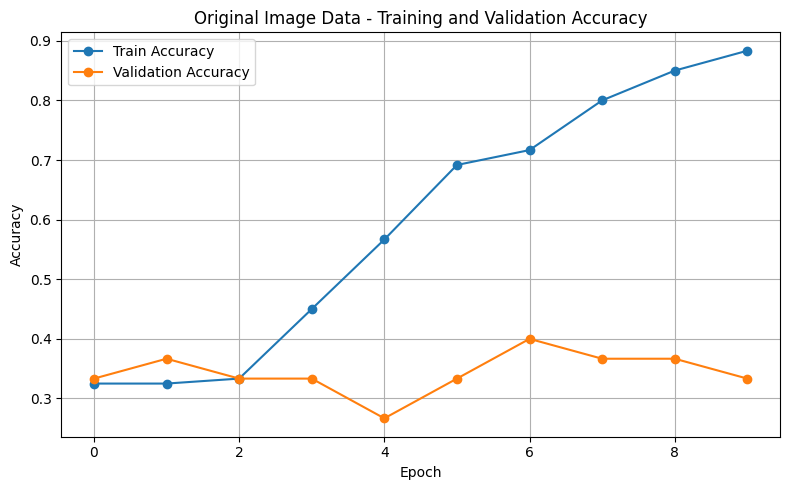

In [21]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Step 1: Reshape grayscale images to match CNN input requirements
# Shape: (samples, height, width, channels) = (N, 64, 64, 1)
X_orig_train = X_train.reshape(-1, 64, 64, 1)
X_orig_test = X_test.reshape(-1, 64, 64, 1)

# Step 2: Normalize pixel values to range [0, 1]
X_orig_train = X_orig_train / 255.0
X_orig_test = X_orig_test / 255.0

# Step 3: One-hot encode the labels (for categorical classification)
y_orig_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_orig_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=3)

# Step 4: Define a simple CNN architecture using original image data
model_orig = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # Output layer for 3 classes
])

# Step 5: Compile the model
model_orig.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Step 6: Train the model using the original image data
history_orig = model_orig.fit(
    X_orig_train, y_orig_train_cat,
    epochs=10,
    batch_size=8,
    validation_data=(X_orig_test, y_orig_test_cat)
)

# Step 7: Evaluate the model on the test set
test_loss_orig, test_acc_orig = model_orig.evaluate(X_orig_test, y_orig_test_cat)
print(f"\nTest accuracy (original image data): {test_acc_orig:.2f}")

# Step 8: Plot and save training vs. validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_orig.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_orig.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Original Image Data - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
plot_path_orig = "visualizations/cnn_accuracy_original_data.png"
plt.savefig(plot_path_orig)
print(f"Plot saved to {plot_path_orig}")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Confusion matrix saved to visualizations\confusion_matrix_original.png


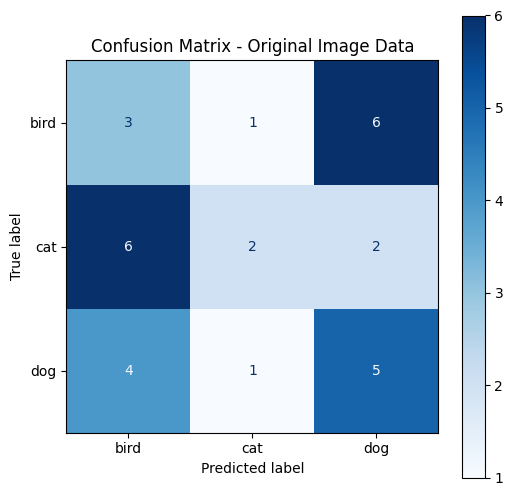

In [22]:
# Import required functions for generating the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os

# Step 1: Use the trained model to predict on the test set
# This returns probabilities, so we use argmax to get class labels
y_pred_probs_orig = model_orig.predict(X_orig_test)
y_pred_orig = np.argmax(y_pred_probs_orig, axis=1)

# Step 2: Compute the confusion matrix
cm_orig = confusion_matrix(y_test, y_pred_orig)

# Step 3: Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm_orig,
                              display_labels=['bird', 'cat', 'dog'])

# Configure plot appearance
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix - Original Image Data")

# Step 4: Save the confusion matrix image
cm_path_orig = os.path.join("visualizations", "confusion_matrix_original.png")
plt.savefig(cm_path_orig)
print(f"Confusion matrix saved to {cm_path_orig}")

plt.show()

### Confusion Matrix – Original Image Data

This confusion matrix shows how well the CNN model performed using the original, uncompressed grayscale images. Each row represents the true class, while each column shows the predicted class.

- The diagonal cells (top-left to bottom-right) indicate correct predictions.
- Off-diagonal cells show misclassifications.
- Misclassification is common across all categories, especially birds and cats.

This visual reinforces that the CNN trained on raw image data has difficulty generalizing, which aligns with the lower validation accuracy observed earlier.